In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.5 MB/s eta 0:00:00


In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 18.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split


In [ ]:
def load_video_frames(video_path, num_frames=16, target_size=(64,64)):
    """
    Load `num_frames` evenly spaced frames from a video, resize, and normalize.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip = max(total_frames // num_frames, 1)

    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i*skip)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = frame / 255.0          # normalize 0-1
        frames.append(frame)

    cap.release()

    # If frames are less than num_frames, pad with last frame
    while len(frames) < num_frames:
        frames.append(frames[-1])

    return np.array(frames)  # shape: (num_frames, H, W, C)


In [ ]:
dataset_dir = "/content/drive/MyDrive/data1"
num_frames = 16
target_size = (64,64)

X, y = [], []
class_names = sorted(os.listdir(dataset_dir))

for label, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_dir, class_name)
    for video_file in os.listdir(class_folder):
        video_path = os.path.join(class_folder, video_file)
        frames = load_video_frames(video_path, num_frames=num_frames, target_size=target_size)
        X.append(frames)
        y.append(label)

X = np.array(X)  # shape: (num_videos, num_frames, H, W, C)
y = np.array(y)
print("Dataset shape:", X.shape, y.shape)
print("Classes:", class_names)


Dataset shape: (163, 16, 64, 64, 3) (163,)
Classes: ['a', 'f', 'n']


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
input_shape = (num_frames, target_size[0], target_size[1], 3)
num_classes = len(class_names)

model = models.Sequential([
    layers.Conv3D(32, (3,3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling3D(pool_size=(1,2,2)),

    layers.Conv3D(64, (3,3,3), activation='relu'),
    layers.MaxPooling3D(pool_size=(2,2,2)),

    layers.Conv3D(128, (3,3,3), activation='relu'),
    layers.MaxPooling3D(pool_size=(2,2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_22 (Conv3D)              │ (None, 14, 62, 62, 32) │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_22 (MaxPooling3D) │ (None, 14, 31, 31, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_23 (Conv3D)              │ (None, 12, 29, 29, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_23 (MaxPooling3D) │ (None, 6, 14, 14, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_24 (Conv3D)              │ (None, 4, 12, 12, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_24 (MaxPooling3D) │ (None, 2, 6, 6, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,459,459 (5.57 MB)

 Trainable params: 1,459,459 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=4
)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 939ms/step - accuracy: 0.3216 - loss: 1.3065 - val_accuracy: 0.3939 - val_loss: 1.1013
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 933ms/step - accuracy: 0.4244 - loss: 1.0939 - val_accuracy: 0.3939 - val_loss: 1.0974
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 936ms/step - accuracy: 0.3734 - loss: 1.1003 - val_accuracy: 0.3939 - val_loss: 1.0948
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 927ms/step - accuracy: 0.3572 - loss: 1.0956 - val_accuracy: 0.3939 - val_loss: 1.0866
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 924ms/step - accuracy: 0.4171 - loss: 1.0695 - val_accuracy: 0.3939 - val_loss: 1.0552
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 930ms/step - accuracy: 0.3467 - loss: 1.0676 - val_accuracy: 0.5152 - val_loss: 1.0531
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 934ms/step - accuracy: 0.4902 - loss: 1.0288 - val_accuracy: 0.6364 - val_loss: 0.9690
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 930ms/step - accuracy: 0.6435 - loss: 0.9524 - val_accu

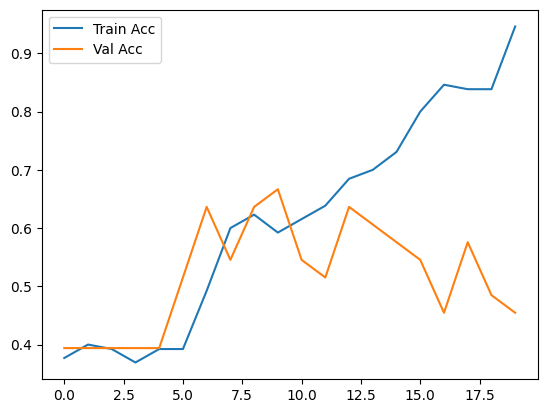

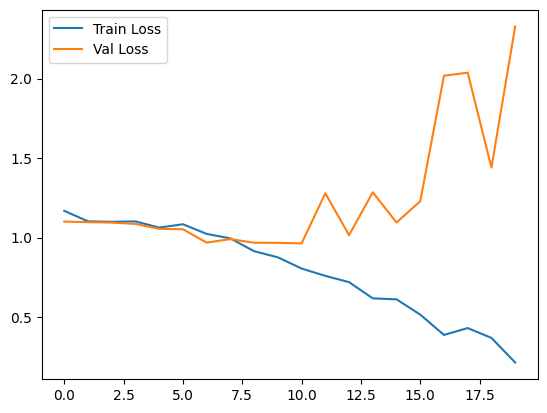

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


In [ ]:
def predict_video(model, class_names, video_path):
    frames = load_video_frames(video_path, num_frames=num_frames, target_size=target_size)
    frames = np.expand_dims(frames, axis=0)  # (1, num_frames, H, W, C)
    pred = model.predict(frames)
    pred_class = class_names[np.argmax(pred)]
    return pred_class

video_path = "/content/drive/MyDrive/data1/Normal_Videos_940_x264.mp4"
pred_class = predict_video(model, class_names, video_path)
print("Predicted class:", pred_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted class: a
